<a href="https://colab.research.google.com/github/rchamchong/DeepLearningTool/blob/main/CatDogClassifyV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# load dogs vs cats dataset, reshape and save to a new file
%matplotlib inline
from zipfile import ZipFile 
import os
from google.colab import drive
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0, Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

In [2]:
# Load data for training
def loadData(file_name, image_size):
  imgs=[]
  files=[]
  labels=[]  

  # opening the zip file in READ mode 
  with ZipFile(file_name, 'r') as zip:
    fileList=zip.namelist() # get list of filename in zip file
    i=0
    for file in fileList:
      if not file.endswith('/'):
        with zip.open(file) as myfile: # open file from zip
          if i%2==0: # this use if limited in your memory
            # load image (PIL) 
            photo=Image.open(myfile)
            # convert to numpy array and store
            imgs.append(img_to_array(photo.resize(image_size)))
            files.append(file.split('/')[2])
            if 'cat' in file:
              labels.append(0)
            else:
              labels.append(1)
          i+=1
  # convert to a numpy arrays
  imgs = np.asarray(imgs,dtype=np.float32)/255.0
  labels = np.asarray(labels, dtype=np.uint8)
  print('Shape of images and labels = (',imgs.shape, labels.shape, ')')

  return imgs, labels, files

  # define MLP ANN model 
def define_modelMLP(input_shape, numClasses):
  inputs = keras.Input(shape=input_shape)
#  x = layers.Rescaling(1.0 / 255)(inputs)
  x=layers.Flatten(input_shape=input_shape)(inputs)
  x=layers.Dense(128, activation='relu')(x)
  x=layers.Dense(256, activation='relu')(x)
  outputs=layers.Dense(numClasses)(x)
  model = keras.Model(inputs, outputs)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

###================== define Lenet5 CNN
def define_modelLenet5(input_shape, numClasses):  
#  model = Sequential()
  inputs = keras.Input(shape=input_shape)

  # C1 Convolutional Layer
  x=layers.Conv2D(6, kernel_size=(5, 5),strides=(1, 1), activation='tanh', input_shape=input_shape)(inputs)
  # S2 Pooling Layer
  x=layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
#    x=Dropout(0.2))
  
  # C3 Convolutional Layer
  x=layers.Conv2D(16, kernel_size=(5, 5),strides=(1, 1), activation='tanh')(x)
  # S4 Pooling Layer
  x=layers.AveragePooling2D(pool_size=(2, 2),strides=(2,2))(x)
#    x=Dropout(0.2))

  # C5 Fully Connected Convolutional Layer
  x=layers.Conv2D(120,  kernel_size=(5, 5), strides=(1, 1), activation='tanh')(x)
#    x=Dropout(0.2))
  #Flatten the CNN output so that we can connect it with fully connected layers
  x=layers.Flatten()(x)

  # FC6 Fully Connected Layer
  x=layers.Dense(84, activation='tanh')(x)
  #Output Layer with softmax activation
  outputs=layers.Dense(numClasses, activation='softmax')(x)
  model = keras.Model(inputs, outputs)
  model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])    

  return model

# define cnn model (VGG 16 layers)
def define_modelVGG16(input_shape, numClasses):
# if do not use VGG16, you can use code as follow
  inputs = keras.Input(shape=input_shape)
  # block1 Convolutional Layer
  x=layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape)(inputs)
  x=layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
  x=layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
  # block2 Convolutional Layer
  x=layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_last')(x)
  x=layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_last')(x)
  x=layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
  # block3 Convolutional Layer
  x=layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_last')(x)
  x=layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_last')(x)
  x=layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_last')(x)
  x=layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same',data_format='channels_last')(x)
  # block4 Convolutional Layer
  x=layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_last')(x)
  x=layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_last')(x)
  x=layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_last')(x)
  x=layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same',data_format='channels_last')(x)
  # block5 Convolutional Layer
  x=layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_last')(x)
  x=layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_last')(x)
  x=layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_last')(x)
  x=layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same',data_format='channels_last')(x)
  
  #Flatten the CNN output so that we can connect it with fully connected layers
  x=layers.Flatten()(x)

  # FC6 Fully Connected Layer
  x=layers.Dense(1024, activation='relu')(x) # original model is: x=layers.Dense(4096, activation='relu'))
  x=layers.Dropout(0.5)(x)
  x=layers.Dense(1024, activation='relu')(x)  # original model is: x=layers.Dense(4096, activation='relu'))
  x=layers.Dropout(0.5)(x)
  #Output Layer with softmax activation
  outputs=layers.Dense(numClasses, activation='softmax')
  model = keras.Model(inputs, outputs)
	# compile model
  model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

Mounted at /content/drive
Shape of images and labels = ( (11250, 128, 128, 3) (11250,) )


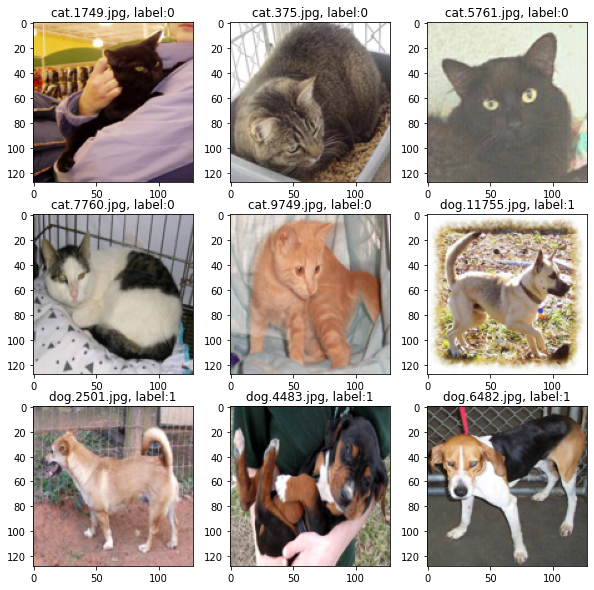

In [3]:
# main
# mount drive in google drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/DeepLearningTool/DogCatClassification/") # change directory
# when the program connect to google drive please authorize your google account to connect your drive at the first time
path=os.getcwd() #read current directory
image_size=(128,128)
# specifying the zip file name 
file_name = os.path.join(path,'dataDogCat/train.zip')
xData, yData, fileName=loadData(file_name, image_size)

# use this to show the image
for i in range(1,10):
	# define subplot
  plt.figure(1,figsize=(10,10))
  plt.subplot(3,3,i)
  # plot raw pixel data
  j=500+i*1000
  plt.imshow(xData[j])
  fname=fileName[j]+', label:'+str(yData[j])
  plt.title(fname)
  
# show the figure
plt.show()
#del fileName

In [4]:
def generateData(xData, yData, image_size, numClasses, batch_size):
  x_train, x_test, y_train, y_test = train_test_split(xData, yData, test_size=0.2, random_state=142)
  data_augment = keras.Sequential(
      [
 #         layers.Normalization(),
          layers.Resizing(image_size[0], image_size[1]),
          layers.RandomFlip("horizontal"),
          layers.RandomRotation(factor=0.02),
          layers.RandomZoom(
              height_factor=0.2, width_factor=0.2
          ),
      ],
      name="data_augmentation",
  )
  # Compute the mean and the variance of the training data for normalization.
#  data_augment.layers[0].adapt(x_train)
  y_train = tf.one_hot(y_train, numClasses)
  y_test = tf.one_hot(y_test, numClasses)

  del xData, yData

  # Now, map the augmentation pipeline to our training dataset
  train_ds = (
      tf.data.Dataset.from_tensor_slices((x_train, y_train))
      .shuffle(batch_size * 100)
      .batch(batch_size)
      .map(lambda x, y: (data_augment(x), y), num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE)
  )

  test_ds = (
      tf.data.Dataset.from_tensor_slices((x_test, y_test))
      .shuffle(batch_size * 5)
      .batch(batch_size)
      .map(
          lambda x, y: (x, y),
          num_parallel_calls=tf.data.AUTOTUNE,
      )
      .prefetch(tf.data.AUTOTUNE)
  )
  del x_train, x_test
  return train_ds, test_ds

In [5]:
### Pretrain model using ResNet50V2
def define_modelPretrain1(input_shape, numClasses):
  base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=input_shape,
    include_top=False)  # Do not include the ImageNet classifier at the top.
  base_model.trainable = False

  inputs = keras.Input(shape=input_shape)
  # We make sure that the base_model is running in inference mode here,
  # by passing `training=False`. This is important for fine-tuning, as you will
  # learn in a few paragraphs.
  x = base_model(inputs, training=False)
  # Convert features of shape `base_model.output_shape[1:]` to vectors
  x = keras.layers.GlobalAveragePooling2D()(x)
  # A Dense classifier with a single unit (binary classification)
  outputs = keras.layers.Dense(numClasses, activation="softmax")(x)
  model = keras.Model(inputs, outputs)
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
  model.compile(
      optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
  )
  return model

def define_modelPretrain(input_shape, numClasses):
  base_model = keras.applications.EfficientNetB0(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=input_shape,
    include_top=False)  # Do not include the ImageNet classifier at the top.
  for layer in base_model.layers:
      #layer.trainable = False
      if isinstance(layer, layers.BatchNormalization):
          layer.trainable = True
      else:
          layer.trainable = False

  inputs = keras.Input(shape=input_shape)
#  x = layers.Rescaling(1.0 / 255)(inputs)
  # We make sure that the base_model is running in inference mode here,
  # by passing `training=False`. This is important for fine-tuning, as you will
  # learn in a few paragraphs.
  x = base_model(inputs, training=False)
  # Convert features of shape `base_model.output_shape[1:]` to vectors
  x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.2,name="top_dropout1")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(512, activation='relu', name='dense1')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.2,name="top_dropout2")(x)
  # x = layers.Dense(256, activation='relu', name='dense2')(x)
  # x = layers.BatchNormalization()(x)
  # x = layers.Dropout(0.2,name="top_dropout3")(x)
  # A Dense classifier with a classes
  outputs = layers.Dense(numClasses, activation="softmax")(x)
  model = keras.Model(inputs, outputs)

  optimizer = keras.optimizers.Adam(learning_rate=1e-2)
  model.compile(
      optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
  )
  return model

# plot diagnostic learning curves
def summarize_diagnostics(history,path,selectmodel):
  # plot loss
  plt.figure(figsize=(6,10))
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='validation')
  plt.legend()
	# plot accuracy
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='validation')
  plt.legend()
  # save plot to file
  filename = os.path.join(path,'summary_plot.png')
  print(filename)
  plt.savefig(filename)
  plt.show()
  plt.close()

In [6]:
# run the test harness for evaluating a model
def process(train_ds, test_ds, input_shape, numClasses, selectmodel='Lenet5',batch_size=32, epoch=20):
  # use GPU and test GPU found if you don't have GPU please comment
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))
  # prepare iterators

  # define model
  if selectmodel=='Lenet5':
    model = define_modelLenet5(input_shape, numClasses)
  elif selectmodel == 'MLP':
    model = define_modelMLP(input_shape, numClasses)
  elif selectmodel == 'VGG16':
    model = define_modelVGG16(input_shape, numClasses)
  else:
    model = define_modelPretrain(input_shape, numClasses)
  model.summary()
  keras.utils.plot_model(model, show_shapes=True)

  # early_stopping_patience = 15
  # # Add early stopping
  # early_stopping = keras.callbacks.EarlyStopping(
  #     monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
  # )

  # fit model
  history = model.fit(train_ds, validation_data=test_ds, epochs=epoch)
  # if need the early_stopping
  # history = model.fit(train_ds, validation_data=test_ds, epochs=epoch, callbacks=[early_stopping])

  # save model
  model.save('final_model_%s.h5'%selectmodel)
  return model,history

In [7]:
numClasses=2
batch_size=64
train_gen, test_gen=generateData(xData, yData, image_size, numClasses, batch_size)
del xData, yData

Found GPU at: /device:GPU:0
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 124, 124, 6)       456       
                                                                 
 average_pooling2d (AverageP  (None, 62, 62, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 29, 29, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (N

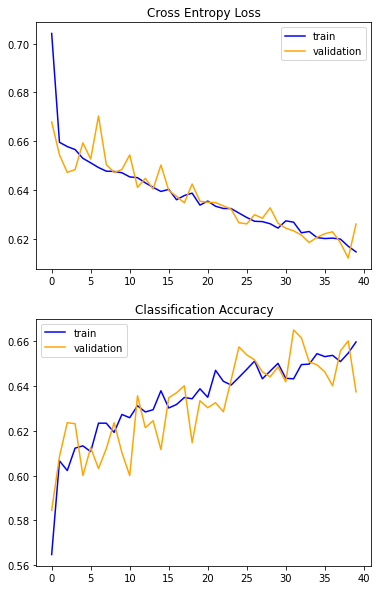

In [9]:
# entry point, run the test harness
# generate Data
input_shape=(image_size[0], image_size[1], 3) # for pretrain model
epoch=40
selectmodel='Lenet5'
#selectmodel='Pretrain'
start = time.time()
model, history=process(train_gen, test_gen, input_shape, numClasses, selectmodel, 
                       batch_size, epoch)
done = time.time()
elapsed = done - start
time_str=time.strftime("ETA of each round=%H:%M:%S\n", time.gmtime(elapsed))
print(time_str)

# evaluate model
_, acc = model.evaluate(test_gen, steps=len(test_gen))
#_, acc = model.evaluate(valid_it, verbose=2)
print('Accuracy= %.3f' % (acc * 100.0))
# learning curves
summarize_diagnostics(history,path,selectmodel)

Found GPU at: /device:GPU:0
16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 top_dropout1 (Dropout)      (None, 1280)              0         
                                  

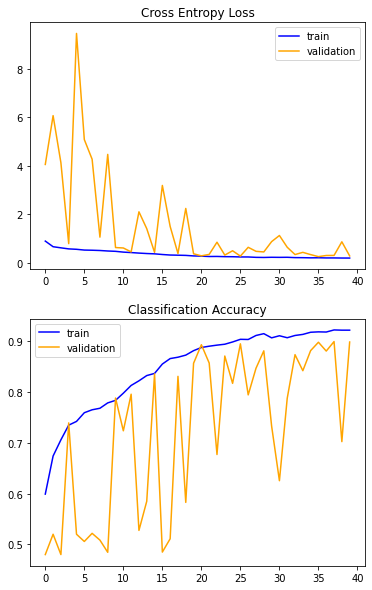

In [8]:
input_shape=(image_size[0], image_size[1], 3) # for pretrain model
# entry point, run the test harness
# input_shape=(128, 128, 3) # for other models
epoch=40
selectmodel='Pretrain'
start = time.time()
model, history=process(train_gen, test_gen, input_shape, numClasses, selectmodel, 
                       batch_size, epoch)
done = time.time()
elapsed = done - start
time_str=time.strftime("ETA of each round=%H:%M:%S\n", time.gmtime(elapsed))
print(time_str)

# evaluate model
_, acc = model.evaluate(test_gen, steps=len(test_gen))
#_, acc = model.evaluate(valid_it, verbose=2)
print('Accuracy= %.3f' % (acc * 100.0))
# learning curves
summarize_diagnostics(history,path,selectmodel)

In [15]:
del train_gen, test_gen

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 2s 2s/step
[[9.998764e-01 1.235976e-04]] 0 cat.10009.jpg
1/1 [==============================] - 0s 23ms/step
[[0.9939761 0.0060238]] 0 cat.11024.jpg
1/1 [==============================] - 0s 21ms/step
[[9.999782e-01 2.184002e-05]] 0 cat.12309.jpg
1/1 [==============================] - 0s 24ms/step
[[0.9972705  0.00272945]] 0 cat.2094.jpg
1/1 [==============================] - 0s 29ms/step
[[0.98008096 0.01991899]] 0 cat.3263.jpg
1/1 [==============================] - 0s 25ms/step
[[0.9964736  0.00352642]] 0 cat.433.jpg
1/1 [==============================] - 0s 24ms/step
[[0.99896383 0.00103612]] 0 cat.5441.jpg
1/1 [==============================] - 0s 25ms/step
[[0.9860875  0.01391251]] 0 cat.6479.jpg
1/1 [==============================] - 0s 27ms/step
[[0.9985911  0.00140885]] 0 cat.7613.jpg
1/1 [=======================

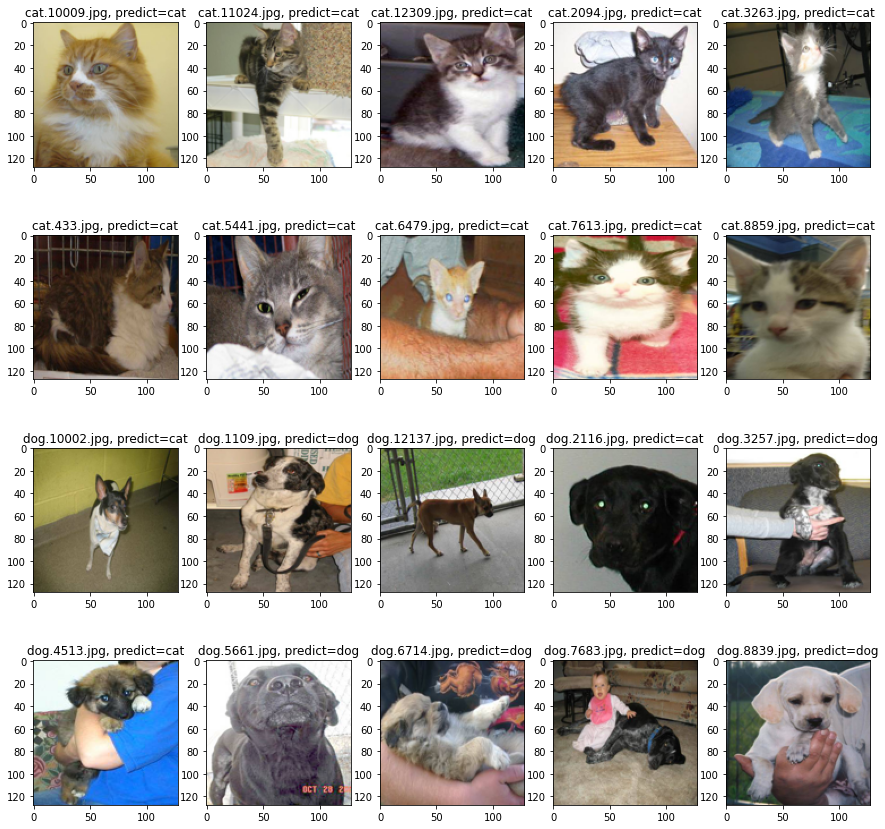

In [17]:
from tensorflow.keras.models import load_model
# LoadData for Testing
def loadTestData(file_name):
  imgs=[]
  files=[]
  labels=[]
  # opening the zip file in READ mode
  i=0 
  with ZipFile(file_name, 'r') as zip:
    fileList=zip.namelist() # get list of filename in zip file
    for file in fileList:
      if not file.endswith('/'):
        with zip.open(file) as myfile: # open file from zip
          if i%125==0:
            # load image, convert to numpy array and store
            imgs.append(Image.open(myfile).resize(image_size))
            files.append(file.split('/')[2])
            if 'cat' in file:
              labels.append(0)
            else:
              labels.append(1)
          i+=1

  return imgs, labels, files

drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/DeepLearningTool/DogCatClassification/") # change directory
path=os.getcwd() #read current directory

# specifying the zip file name and load test data
file_name = os.path.join(path,'dataDogCat/test.zip')
xTest, yTest, dFile = loadTestData(file_name)
# load model
model=load_model('final_model_Pretrain.h5')

# read data
for i in range(0,20):
  # predict the class
  image=img_to_array(xTest[i])
  # if i==1 : 
  #   print(image.shape)
  # expand dimension for the same input of model at axis 0 (row dimension)
  image=np.expand_dims(np.array(image), 0)
  # predict the image (image should be devide by 255.0 to be prob)
  result = model.predict(image/255.0)
#  y_true = np.argmax(yTest[i]) # use for check accuracy
  y_pr = np.argmax(result[0])
  print(result,y_pr,dFile[i])
  if y_pr==0:
    out='cat'
  else:
    out='dog'
	# define subplot
  plt.figure(1,figsize=(15,15))
  plt.subplot(4,5,i+1)
  # plot raw pixel data
  plt.imshow(xTest[i])
  plt.title(dFile[i]+', predict='+out)

# show the figure
plt.show()